<h1 style="font-size:30px;">Unlock the Power of Fine-Tuning Pre-Trained Models in Tensorflow & Keras</h1>  

In this notebook, we will explore options for leveraging pre-trained models that you can use for your own datasets. This is especially useful when you have a limited dataset and limited computational resources. We will first summarize several options for leveraging pre-trained models, but the real power comes from Fine Tuning, which is the focus of this notebook.

<img src='https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-fine-tune-architecture-feature-image-NB.png' width=680 align='center'>

We will demonstrate Fine-Tuning in the context of image classification using the VGG-16 network, but the concepts we cover here are not specific to any particular model or task. Fine-Tuning is especially useful when you have a limited dataset and/or limited computational resources. However, before we get into the details of Fine-Tuning, we will first summarize several options for leveraging pre-trained models, which include:

1. Using Pre-Trained models out of the box
2. Training models from scratch
3. Transfer Learning
4. Fine-Tuning

In the implementation below, we will use a modified version of the German Traffic Sign Recognition Benchmark (GTSRB), a well-known classification dataset that contains German traffic signs from 43 classes. The entire dataset (Train and Test) contains over 50,000 images. However, to demonstrate the power of Fine-Tuning on small datasets, we have carved out a small percentage of the original dataset to include just 40 samples per class (28 for training and 12 for validation). To evaluate how well the model generalizes, we will use the original test dataset, which contains 12,630 samples.

## Table of Contents

* [1 Overview of Training Options](#1-Overview-of-Training-Options)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Create Train and Validation Datasets](#4-Create-Train-and-Validation-Datasets)
* [5 Create the Test Dataset](#5-Create-the-Test-Dataset)
* [6 Modeling VGG-16 (for Fine-Tuning)](#6-Modeling-VGG-16-(for-Fine-Tuning))
* [7 Model Evaluation](#7-Model-Evaluation)
* [8 Conclusion](#8-Conclusion)

## 1 Overview of Pre-Trained Model Use Cases

Before we proceed with the coding implementation for Fine Tuning, it's helpful to review the table below, which summarizes several use cases. In a previous notebook, we showed how you can use pre-trained ImageNet models to perform classification.

### 1.1 Pre-Trained ImageNet Models

If you have a need to perform image classification on a wide range of content that encompasses many of the classes in ImageNet, then using a pre-trained model is an excellent choice. As the name implies, no training is required; you can simply load the model and make predictions on your pre-processed input images. There are many pre-trained models available in Keras, which you can select from. See our previous post on this topic for more details.

For situations where your application contains specific classes that are not contained in ImageNet, you have three additional options. The Keras applications API conveniently provides access to many CNN classification models, which you can load into memory, customize, and train.

<img src=https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-training-methods.png width=850 align='left'><br/>

The sections below summarize the process for each option. It's worth emphasizing that for each training method below, a new classifier needs to be defined for your custom dataset since the pre-trained models in Keras assume an ImageNet classifier with 1,000 outputs. We will cover how to do this in the coding implementation later on in this notebook.

### 1.2 Train from Scratch

If you need to customize a model for a new dataset, one option is to load a model and train it from scratch. When training from scratch, the entire model is initialized with random weights, and training is performed from scratch (with the redefined classifier).

 Training a model from scratch requires a lot of data and a lot of computational resources, although this depends on the size of the model. Still, it's a significant factor to consider, especially if you don't have much data and acquiring labeled training data for your application is difficult. Better options exist, but for reference, we trained the VGG-16 model from scratch on this small dataset to establish a baseline performance. No attempt was made to tune hyper-parameters, but we did use a dropout layer in the classifier, which is needed to mitigate over-fitting with such a small dataset. We will come back to these plots later and compare them to the fine-tuning results.

<img src='https://learnopencv.com/wp-content/uploads/2023/02/tensorflow-keras-train-from-scratch-plots.png' width=870 align='center'>

Even though we added a dropout layer, there is still evidence that the model is overfitting since the validation loss is quite a bit higher than the training loss. With such a small dataset, it is difficult for the model to learn well enough that it generalizes to unseen data.

One thing worth mentioning here is that the initial loss should be somewhat close to random chance. For categorical cross-entropy, the loss is the negative log of the probability of the correct class. Initially, we would expect the probability of the correct class to be roughly equal to (1/43), and therefore the initial loss should be somewhat close to 3.76.

$$loss = -log(\frac{1}{43}) = 3.76$$

This is a good sanity check, which we can confirm in the loss plot above.

### 1.3 Transfer Learning

Transfer Learning is a simple approach for re-purposing a pre-trained model to make predictions on a new dataset. The concept is simple. We use the model's pre-trained feature extractor (convolutional base) and re-train a new classifier to learn new weights for the new dataset. This is sometimes referred to as "freezing" the layers in the feature extractor, meaning that we load the pre-trained weights and do not attempt to modify them further during the training process. The theory is that the pre-trained ImageNet Feature Extractor has learned valuable features for detecting many different object types. We assume such features are general enough that we only need to re-train the classifier portion of the network.

<img src='https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-transfer-learning-architecture.png' width=650 align='center'>

This approach requires much less data and computational resources than training from scratch. Remember that training a model often takes many iterations to determine an appropriate set of hyper-parameters for a final model, so the time required to experiment and iterate will be significantly compounded. Since pre-trained models were trained on millions of images, it behooves us to try and leverage that inherent capability. Transfer learning allows you to quickly study how a pre-trained model can be customized for a new dataset. However, sometimes retraining the classifier isn't enough. This is where Fine-Tuning can be very beneficial.

### 1.4 Fine Tuning

Fine-Tuning represents a flexible alternative to Transfer Learning. It is very similar to Transfer Learning. Instead of locking down the feature extractor completely, we load the feature extractor with ImageNet weights and then freeze the first several layers of the feature extractor but allow the last few layers to be trained further. The idea is that the first several layers in the feature extractor represent generic, low-level features (e.g., edges, corners, and arcs) that are fundamental building blocks necessary to support many classification tasks. Subsequent layers in the feature extractor build upon the lower-level features to learn more complex representations that are more closely related to the content of a particular dataset.

<img src='https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-fine-tune-architecture-feature-image-NB.png' width=650 align='center'>

With Fine-Tuning, we would like to specifically leverage the lower-level features of the pre-trained model but provide some flexibility for "fine-tuning" the last few layers of the convolutional base to provide the best possible customization for the dataset. So we "freeze" the initial layers (i.e., make them non-trainable) and let the model train the last few layers of the feature extractor, as well as the classifier. Notice that all the layers in the feature extractor are initialized to ImageNet weights. Once training begins, the weights in the last few layers of the feature extractor are updated further, which is why this approach is called Fine-Tuning. Also, notice that the weights in the classifier are initialized to small random values since we want the classifier to learn new weights required to classify new content.

In the remainder of this notebook, we will focus on the Fine-Tuning implementation. We will also spend some time preparing the test dataset, which is in a different format than the training and validation datasets. This presents a good opportunity to explore the methods and techniques that are used to manage image data that are organized differently on the file system.

In [1]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from dataclasses import dataclass

from zipfile import ZipFile
from urllib.request import urlretrieve

In [2]:
SEED_VALUE = 41

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## 2 Download and Extract the Dataset

The German Traffic Sign Recognition Benchmark ([GTSRB](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)) is a well-known classification dataset that contains German traffic signs from 43 classes. The entire dataset (Train and Test) contains over 50,000 images. The training set alone contains over 39,000 images.

To demonstrate how to leverage pre-trained models for cases when you may have a limited-size dataset, we have created a small version of the GTSRB dataset, which contains just 40 images per class. It's important to note that many of the images from the dataset are taken from video frames. Therefore many of the images in the original training dataset are near duplicates. We, therefore, created a small version of the dataset by sampling every nth image sample to maintain a wide variety of images rather than using the first 40 samples from each class. Additionally, we created a separate validation dataset from the training dataset for convenience. The training dataset contains 28 images per class, and the validation dataset contains 12 images per class. The following code cells will download and extract the dataset to your local system.

In [3]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [4]:
URL = r"https://www.dropbox.com/s/uzgh5g2bnz40o13/dataset_traffic_signs_40_samples_per_class.zip?dl=1"

dataset_path   = os.path.join(os.getcwd(), "dataset_traffic_signs_40_samples_per_class")
asset_zip_path = os.path.join(os.getcwd(), "dataset_traffic_signs_40_samples_per_class.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

## 3 Dataset and Training Configuration

Here we can use the Python dataclasses module to create two classes to configure data and training parameters conveniently. Notice that we specified `LAYERS_FINE_TUNE = 8`, which is a Fine-Tuning configuration parameter to indicate that we want to Fine-Tune the last eight layers of the VGG-16 model. This is value that you will need to experiment with. You can also try setting this to 4, which would only Fine-Tune the last four layers of the convolutional base.

In [5]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3

    DATA_ROOT_TRAIN:  str = os.path.join(dataset_path, "Train")
    DATA_ROOT_VALID:  str = os.path.join(dataset_path, "Valid")
    DATA_ROOT_TEST:   str = os.path.join(dataset_path, "Test")
    DATA_TEST_GT:     str = os.path.join(dataset_path, "Test.csv")


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

## 4 Create Train and Validation Datasets

Here we use `image_dataset_from_directory()`, a very convenient utility in Keras for creating an image dataset. The expected file structure for a dataset is shown below, where the images for each class are contained in a separate class sub-folder.

```bash
main_directory/
    class_a/
        a_image_1.png
        a_image_2.png
    class_b/
        b_image_1.png
        b_image_2.png
```

The function is documented [here](https://keras.io/api/preprocessing/image/). It has only one required argument, which is the top-level folder for the dataset, but there are several optional arguments that can be used to configure the dataset. We highlight a few even though we are using the default values for some of them. Among them, we have the option for how to specify the label encoding. Here we decided to use integer encoding, which is the default (`label_mode='int'`), rather than one-hot label encoding. Either option can be used, but there is additional code further below in this implementation that assumes integer encoding.

In [6]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int', # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int', # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 1204 files belonging to 43 classes.
Found 516 files belonging to 43 classes.


In [7]:
# Display the class names from the training dataset.
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


Notice that the inferred class names are in an alpha-numeric sequence as opposed to  numeric order. **This is an important observation that we will need to consider when we build the test dataset.**

### 4.1 Display Sample Images from Training Dataset

It's always a good idea to visually inspect some of the images from the dataset. As you can see below, the image quality varies significantly.  

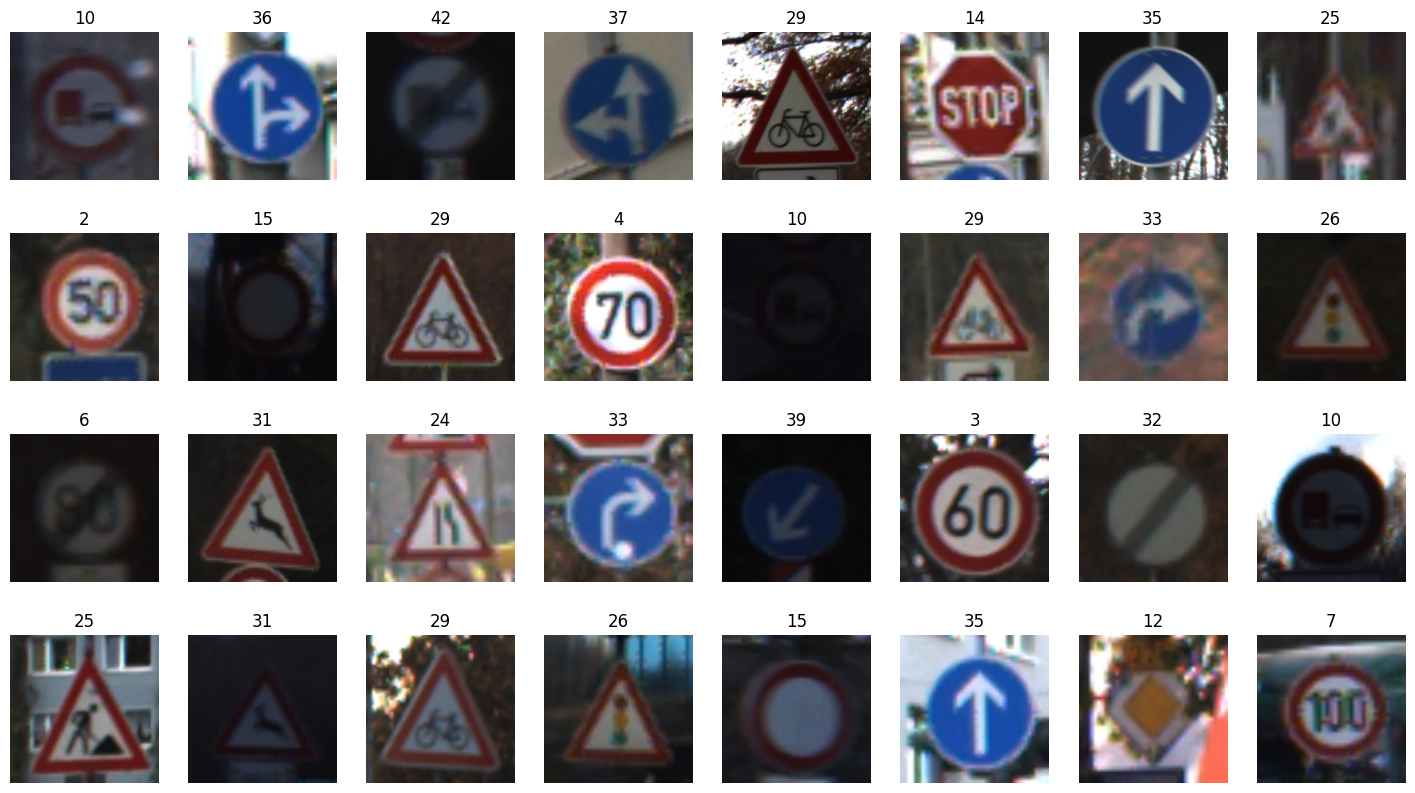

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

## 5 Create the Test Dataset

It was easy to create the training and validation datasets using `image_dataset_from_directory()`. However, since the images and labels for the Test dataset are stored separately on the filesystem, we'll need to write some custom code to read and load this data. To create the test dataset, we will need to load the images and the labels in memory and combine them to create a (`tf.data.Dataset`) test dataset. Four steps are required:

1. Retrieve the class labels from the provided `csv` file and store them in memory as a Python list
2. Build a list of the image file paths in memory as a Python list
3. Combine the image paths and associated labels in a `tf.data.Dataset` object
4. Use the dataset object `map` method to the load and preprocess the images in the dataset


### 5.1 Load Test Ground Truth Labels

The ground truth labels for the test dataset are listed in a `csv` file (`Test.csv`). The first few samples from the file are shown below for reference.

<img src=https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-test-dataset-ground-truth.png width=800 align='left'><br/>

We can easily extract the class IDs from this file using a Pandas dataframe. The following code cell reads the class IDs from this file and stores them in a Python list.

In [20]:
import pandas as pd

input_file = DatasetConfig.DATA_TEST_GT

dataset = pd.read_csv(input_file)
df = pd.DataFrame(dataset)
cols = [6]
df = df[df.columns[cols]]
ground_truth_ids = df["ClassId"].values.tolist()
print("Total number of Test labels: ", len(ground_truth_ids))
print(ground_truth_ids[0:10])

Total number of Test labels:  12630
[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]


Notice that these labels match the first 10 labels from the ground truth file, which is what we expect. However, recall that the class names in the train and validation datasets have an alphanumeric order that is no longer in a numerical sequence. This is a unique issue with this dataset due to the class names being composed of digits which get sorted alphabetcially versus in numerical sequence. We, therefore, need to provide the same mapping in the test dataset.

In [21]:
# For referenece, let's print the class names from the train/valid datasets again.
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


### 5.1.1 Map Ground Truth Class IDs to  IDs in Train/Valid Datasets

To create a test dataset that is consistent with the label IDs in the training and validation datasets we need to build a dictionary mapping ground truth IDs in the test dataset to class name IDs. This will ensure that the ground truth labels in the test dataset are correctly interpreted by the model.

***Note***: This step is not normally required but is an artifact of the way the class names were inferred from the class folder names. An alternative solution would be to use the `class_names` argument in `image_dataset_from_directory()`, in which we explicitly specify the order of the class names to be in numerical order.

In [22]:
# Convert train/valid class names to integers.
class_names_int = list(map(int, train_dataset.class_names))

# Create a dictionary mapping ground truth IDs to class name IDs.
gtid_2_cnidx = dict(zip(class_names_int, range(0, DatasetConfig.NUM_CLASSES)))

gtid_2_cnidx.items()

dict_items([(0, 0), (1, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (2, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 20), (28, 21), (29, 22), (3, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29), (36, 30), (37, 31), (38, 32), (39, 33), (4, 34), (40, 35), (41, 36), (42, 37), (5, 38), (6, 39), (7, 40), (8, 41), (9, 42)])

In [23]:
# Convert the ground truth Class IDs to IDs that correctly map to the same classes
# in the train and validation datasets.
label_ids = []
for idx in range(len(ground_truth_ids)):
    label_ids.append(gtid_2_cnidx[ground_truth_ids[idx]])

print("Original ground truth class IDs: ", ground_truth_ids[0:10])
print("New mapping required:            ", label_ids[0:10])
print("")
print("Train/Valid dataset class names: ", train_dataset.class_names)

Original ground truth class IDs:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35]
New mapping required:             [8, 1, 32, 27, 3, 32, 10, 4, 18, 29]

Train/Valid dataset class names:  ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


### 5.2 Create File Paths to Test Images

Next, we create a list of file paths for each of the images in the Test dataset.

In [24]:
# Get all the path names to the Test images (will prune later)
image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + os.sep + "*.png"))

print(len(image_paths))
print("")
# Print the first 5 image paths to confirm.
for idx in range(5):
    print(image_paths[idx])

12630

/content/dataset_traffic_signs_40_samples_per_class/Test/00000.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00001.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00002.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00003.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00004.png


### 5.3 Combine images and labels to create the Test dataset

We can now use `from_tensor_slices()` to combine the image paths and image labels in a `tf.data.dataset`.

In [25]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

### 5.4 Load and Preprocess the Images
We still need to load the dataset into memory and preprocess the images. For this, we define three convenience functions for loading and resizing test images in the code cells below.

In [15]:
def preprocess_image(image):
    # Decode and resize image.
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH])
    return image

In [16]:
def load_and_preprocess_image(path):
    # Read image into memory as a byte string.
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [17]:
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

Next, we load and preprocess the images using the test dataset's `map()` method to call the functions above. And we also set the batch size of the dataset.

In [37]:
# Apply the functions above to the test dataset.
test_dataset = test_dataset.map(load_and_preprocess_from_path_label)

# Set the batch size for the dataset.
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)

### 5.5 Display Sample Images from the Test Dataset

To confirm we have properly created the test dataset, we will display the images from the first batch. Even though this is a very small sample size, it's pretty clear the test images have a wide range in image quality, with several images severely under-exposed.

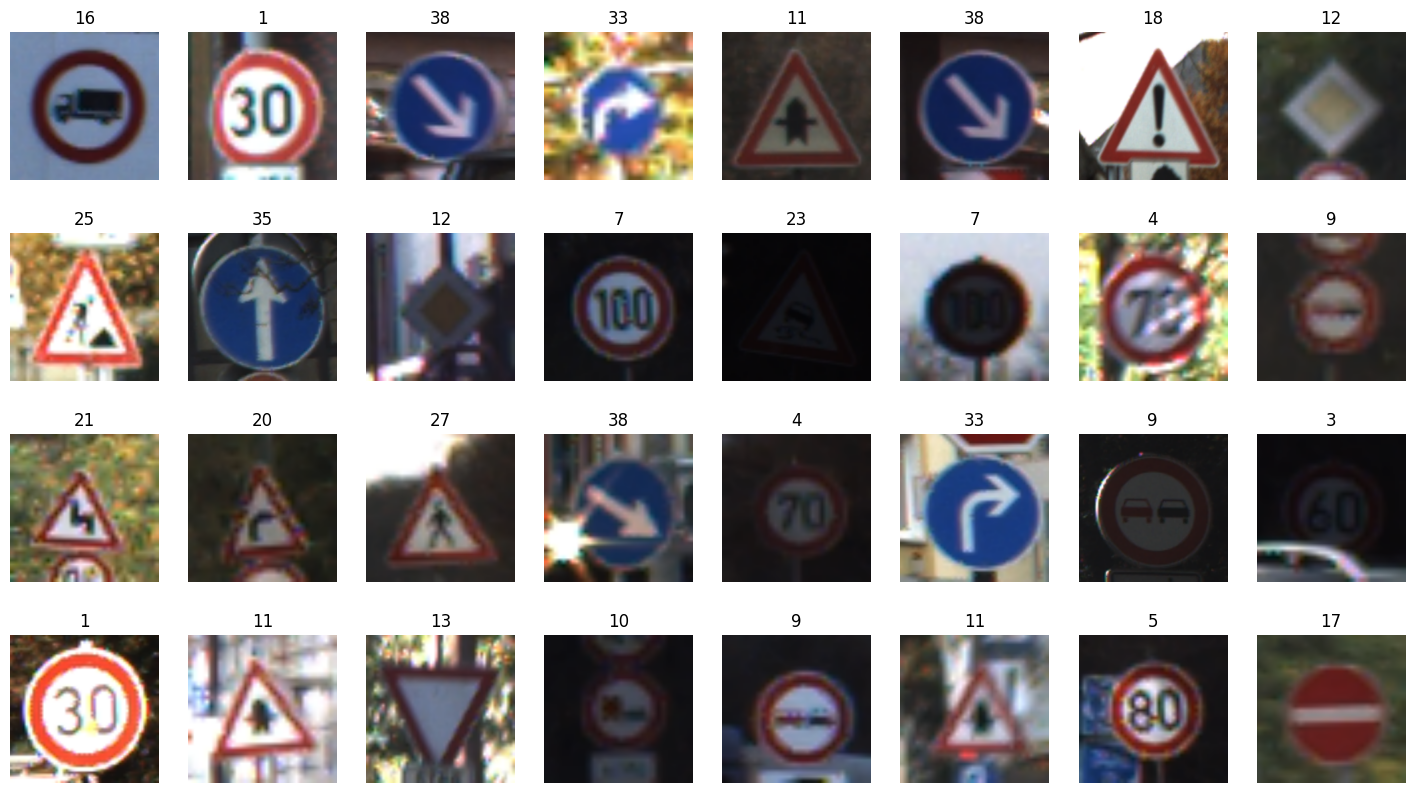

In [19]:
plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the test dataset.
for image_batch, labels_batch in test_dataset.take(1):

    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

## 6 Modeling VGG-16 (for Fine-Tuning)

The Keras API provides the following utility that is used to instantiate a VGG-16 model. The default settings are shown below for the pre-trained ImageNet model.

```python
tf.keras.applications.vgg16.VGG16(include_top=True,
                                  weights='imagenet',
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```

To configure the model for Fine-Tuning, we will load the model's convolutional base with weights that were learned from the ImageNet dataset. These weights serve as a starting point for Fine-Tuning the model for our dataset. Since we need to redefine the classifier, we will load the model without a classifier (`include_top=False`), so we can specify our own classifier for the dataset.

For more information on the VGG-16 model available in Keras, here is the documentation link: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>.

### 6.1 Loading the VGG-16 Convolutional Base

We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False`, which excludes the fully connected layers. We will also instantiate the model with weights that were learned by training the model on the ImageNet dataset `weights='imagenet'`.


In [26]:
# Specify the model input shape.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
vgg16_conv_base.summary()

Loading model with ImageNet weights...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 6.2 Freeze the Initial Layers in the Convolutional Base

Now that we have loaded the convolutional base, we need to lock down the initial layers so that only the last few laters (`TrainingConfig.LAYERS_FINE_TUNE = 8`) are trainable. There are two ways to specify which layers in the model are trainable (tunable).

1. We can start by making the entire convolutional base trainable by setting the trainable flag to True. Then loop over the initial layers and make them untrainable by setting the same (`trainable`) flag for each layer to False.

2. We can freeze the entire convolutional base by setting the trainable flag to False, and then loop over the last few layers and set the `trainable` flag to `True`.

We use the first approach in the code cell below. We start by setting the entire convolutional base as "trainable" by setting the `trainable`e attribute to `True`.

In [27]:
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[: num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last {num_layers_fine_tune} convolutional layers...")
print("\n")

vgg16_conv_base.summary()

FREEZING LAYER: <InputLayer name=input_layer, built=True>
FREEZING LAYER: <Conv2D name=block1_conv1, built=True>
FREEZING LAYER: <Conv2D name=block1_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block1_pool, built=True>
FREEZING LAYER: <Conv2D name=block2_conv1, built=True>
FREEZING LAYER: <Conv2D name=block2_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block2_pool, built=True>
FREEZING LAYER: <Conv2D name=block3_conv1, built=True>
FREEZING LAYER: <Conv2D name=block3_conv2, built=True>
FREEZING LAYER: <Conv2D name=block3_conv3, built=True>
FREEZING LAYER: <MaxPooling2D name=block3_pool, built=True>


Configured to fine tune the last 8 convolutional layers...




Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Notice in the model summary above the number of trainable parameters is now lower.

### 6.3 Add the Classifier to Complete the Model

Since we intend to train and use the model to classify traffic signs (43 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 128 nodes, followed by a softmax output layer that contains 43 nodes for each of the 43 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset. Because we are working with a very small dataset (40 samples per class), the model will be prone to overfitting, so we have also added a dropout layer in the classifier. The entire model is then assembled as shown below.

In [28]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = vgg16_conv_base(x)

# Flatten the output from the convolutional base.
x = layers.Flatten()(x)

# Add the classifier.
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)

# Output layer.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation="softmax")(x)

# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)

model_vgg16_finetune.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 43)             │          5,547 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,931,627 (68.40 MB)

 Trainable params: 16,196,139 (61.78 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

## 6.4 Compile and Train the Model

Here we use `SparseCategoricalCrossentropy` since we are using integer-encoded labels. For one-hot encoded labels, the appropriate loss function would be `CategoricalCrossentropy`. Since we included a Softmax layer in the model output, we specify `from_logits=False`. This is the default setting, but it's good practice to be explicit. Alternatively, you can remove the softmax layer in the model and set `from_logits=True`, and the loss function will apply the softmax function internally. The results should be identical.

In [29]:
# Use this for integer encoded labels.
model_vgg16_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [30]:
# Train the Model.
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=TrainingConfig.EPOCHS,
                                            validation_data=valid_dataset,
                                           )

Epoch 1/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 995ms/step - accuracy: 0.0238 - loss: 6.7582 - val_accuracy: 0.0329 - val_loss: 3.7220
Epoch 2/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 341ms/step - accuracy: 0.0492 - loss: 3.7250 - val_accuracy: 0.0640 - val_loss: 3.6169
Epoch 3/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.0701 - loss: 3.5971 - val_accuracy: 0.1202 - val_loss: 3.3740
Epoch 4/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.1188 - loss: 3.3293 - val_accuracy: 0.2616 - val_loss: 2.8081
Epoch 5/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - accuracy: 0.2445 - loss: 2.8281 - val_accuracy: 0.3488 - val_loss: 2.4934
Epoch 6/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 409ms/step - accuracy: 0.3237 - loss: 2.4512 - val_accuracy: 0.4419 - val_loss: 1.9928
Epoch 7/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.4529 - loss: 1.9145 - val_accuracy: 0.6318 - val_loss: 1.4968
Epoch 8/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 360ms/step - accuracy: 0.5510 - loss: 1.5289 - 

### 6.4 Plot the Training Results

The convenience function below is used to plot both the training and validation loss and accuracy.

In [31]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

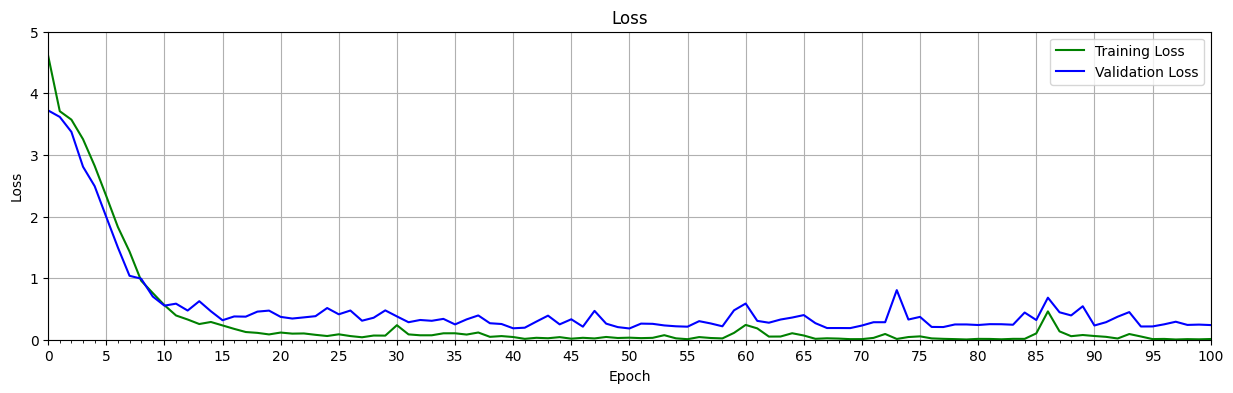

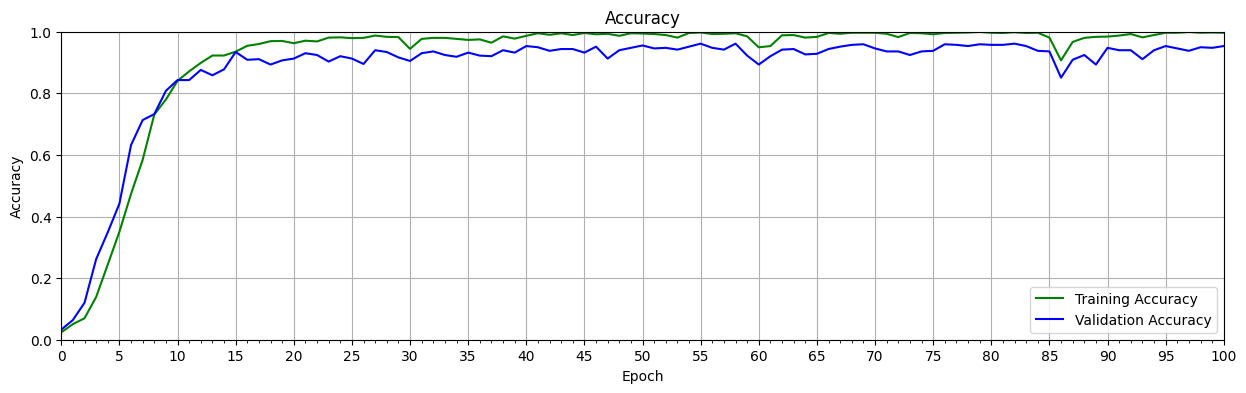

In [32]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

The training plots above clearly show a rapid decrease in loss and increase in accuracy, which can be attributed to the model being initialized with pre-trained weights. It's worth noting that despite the small size of the dataset and the variations in image quality, the validation accuracy is impressive, exceeding 95%. Techniques such as data augmentation could be employed to improve the accuracy even further. Overall, these results are encouraging and indicate that the model has learned to generalize well to unseen data.

### 6.4.1 Comparison: Fine-Tuning vs. Training from Scratch

For convenience, we have included a side-by-side view to show the difference between training the model from scratch and fine-tuning the model. There are several things to note. First, notice that training from scratch takes longer. For example, the validation accuracy for fine-tuning reaches 80% after just 15 epochs, while training from scratch needs a full 100 epochs to get close to the same value. Also, notice that training from scratch is more prone to over-fitting even though both models were implemented with the same dropout layer in the classifier. Finally, the validation accuracy of the fine-tuned model is about 17% higher.

<img src=https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-model-comparison-plots.png width=950 align='left'><br/>

## 7 Model Evaluation

We can see the train and validation accuracy in the plots above, but it's helpful to use the model's `evaluate()` method to compute the value at the last epoch. Here we confirm that the validation accuracy is nearly 97%.

### 7.1 Validation Dataset

In [33]:
print(f"Model valid accuracy: {model_vgg16_finetune.evaluate(valid_dataset)[1]*100.:.3f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9642 - loss: 0.1648
Model valid accuracy: 95.349


### 7.2 Test Dataset

It's also important to evaluate the model on the Test dataset, which is very large (12,630 images). This is especially true since the number of samples in the validation dataset is pretty small (only 12 samples per class). As shown below, the accuracy achieved on the test dataset is `96.26%` which in this case is very comparable to the validation accuracy, but this won't always be the case.

In [38]:
print(f"Model test accuracy: {model_vgg16_finetune.evaluate(test_dataset)[1]*100.:.3f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 78s 198ms/step - accuracy: 0.9630 - loss: 0.2241
Model test accuracy: 96.255


### 7.3 Display Sample Predictions

Here we create a convenience function to plot some sample predictions from both the validation and test datasets. It can be helpful to visually spot-check prediction results. Each displayed image contains a title with the ground truth label (left) and the predicted label (right). If the predicted label is incorrect, the title is displayed in red to highlight the incorrect result.

In [39]:
def display_predictions(dataset, model, class_names):

    plt.figure(figsize=(20, 20))
    num_rows = 8
    num_cols = 8
    jdx = 0

    # Evaluate two batches.
    for image_batch, labels_batch in dataset.take(2):
        print(image_batch.shape)

        # Predictions for the current batch.
        predictions = model.predict(image_batch)

        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()

            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color = "g"
            else:
                color = "r"

            jdx += 1

            if jdx > num_rows * num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break

            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])

            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return

### 7.3.1 Display Sample Validation Results

Since the validation accuracy is about 97%, we might expect a couple of mistakes out of the 64 samples. As you can see below, there are two misclassifications.

In [40]:
display_predictions(valid_dataset, model_vgg16_finetune, class_names)

Output hidden; open in https://colab.research.google.com to view.

### 7.3.2 Display Sample Test Results

For the test dataset, we see that there are four misclassifications. Notice that in each case, the misclassifications involve signs that are very similar (e.g., the precicted signs have the same shape as the test samples).

In [41]:
display_predictions(test_dataset, model_vgg16_finetune, class_names)

Output hidden; open in https://colab.research.google.com to view.

## 8 Conclusion

Fine-tuning pre-trained models is a powerful technique that allows you to re-purpose a model for a custom dataset. Keras comes bundled with many pre-trained classification models, allowing you to conveniently load a model in memory and configure it for Fine-Tuning. Let's summarize the key steps required for fine-tuning a pre-trained model.

When fine-tuning pre-trained models, we only load the convolutional base of the model, which is initialized with ImageNet weights.  We "freeze" the first few layers of the convolutional base but allow the last few layers to be trained ("fine-tuned"). These steps are accomplished with the model's trainable attribute to toggle which layers are trainable and which are not. The number of layers to fine-tune is something you need to experiment with. The classifier needs to be redefined based on the dataset and is initialized with random weights. In this way, the model's initial state is in a favorable position for continued learning that allows it to adapt to a new dataset and learn faster (and potentially better) than training a model from scratch. This approach also allows the model to be re-purposed for a new dataset with much less data than would be required for training a model from scratch.